# 02.Porto Seguro's Safe Driver Prediction

# 대회 정보

- Porto Seguro는 브라질의 자동차 보험 회사라고 한다.
- 이 대회의 목적은 어떤 차주가 내년에 보험 청구를 할 확률을 예측하는 것
- predict_proba라는 함수를 사용해서 값을 예측 (확률 값)
- 대회의 평가지표는 특이하게 Normalized Gini Coefficient를 사용함
- Normalized Gini Coefficient를 사용하는 이유:   
Imbalanced Class를 평가를 위한 임계값을 어떻게 정하느냐에 따라 예측값이 바뀜   
= ROC 커브로 확인 (면적으로 스코어를 매김) >> 비슷한 목적으로 Gini Coefficient가 쓰임   
= gini = 2 * AUC - 1   
출처: https://stats.stackexchange.com/questions/306287/why-use-normalized-gini-score-instead-of-auc-as-evaluation

### Normalized Gini Coefficient (지니계수)

- 머신러닝 분야에서 Decision Tree모델의 성능을 평가할 때 엔트로피 지수와 함께 쓰인다.   
 결정트리는 트리구조를 형성할때 순도가 증가하고, 불순도가 최대한 작아지는 방향으로 결정을 내려감.   
- 지니 계수는 0~0.5 의 값을 가지는데 값이 작을수록 분류가 잘 되었다고 볼 수 있음   
불순도(섞인 정도)가 적은것이 분류가 잘된것   
- 이 대회에서 지니 계수는 Actual 값의 누적 비율과 Prediciton값의 누적 비율로 산출이되는데, 이것을 표준화 시킨다.   
이 표준화는 Actual값이 가지고 있는 불평등 정도로 actual-prediction간의 불평등 정도를 나누어서 산출된다.

> 해당 캐글 사이트   
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

> 상위 커널   
https://www.kaggle.com/bertcarremans/data-preparation-exploration#Loading-packages

> 상위 커널을 한글로 리뷰한 사이트 참고   
https://www.kaggle.com/whtngus4759/porto-seguro-for-beginner   
https://www.kaggle.com/kongnyooong/porto-seguro-eda-for-korean?scriptVersionId=41425780
https://hmkim312.github.io/posts/Data_Preparation_and_Exploration/

# Section

1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data visualization
7. Feature engineering
8. Feature selection
9. Feature scaling
10. Loading packages

# Loading packages

In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer # 결측치 대체를 위한 라이브러리
from sklearn.preprocessing import PolynomialFeatures # 교호작용 변수 생성 (중요한 변수끼리의 곱)
from sklearn.preprocessing import StandardScaler # 스케일러 사용 (평균을 제거하고 데이터를 단위 분산으로 조정)

from sklearn.feature_selection import VarianceThreshold # FeatureSelection에서 분산이 기준치보다 낮은 feature는 탈락
from sklearn.feature_selection import SelectFromModel # Feature Importance를 제공하는 모델의 importance를 활용하여 변수선택

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

# 1. Visual inspection of your data

## 1) Data Load

In [2]:
data_path = "data/"

df_train = pd.read_csv(data_path+"train.csv")
df_test = pd.read_csv(data_path+"test.csv")

## 2) Data at first sight

- 컬럼 이름(ind, reg, car, calc)로 Grouping된다
- 컬럼 이름에 '_bin'은 Binary Features, '_cat'은 Categorical Features를 의미
- 컬럼 이름에 아무것도 안붙어있으면 Continuous or Ordinal Features를 의미
- -1 은 Null값을 의미

In [3]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
df_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


- 유사한 그룹에 속하는 기능은 기능 이름 (예 : ind, reg, car, calc)에 태그가 지정됩니다.
- 기능 이름에는 이진 기능을 나타내는 접미사 bin과 범주 기능을 나타내는 cat이 포함됩니다.
- 이러한 지정이없는 특징은 연속 형이거나 순서 형입니다.
- -1 값은 관측치에서 피쳐가 누락되었음을 나타냅니다.
- target 열은 해당 보험 계약자에 대한 청구가 접수되었는지 여부를 나타냅니다.

In [5]:
df_train.shape

(595212, 59)

In [6]:
df_test.shape

(892816, 58)

- 데이터의 행과 열을 확인해본다.
- 타겟과 id를 제외한 58개의 feature가 존재한다.
- 특이한 점은 train set이 test set보다 적다.

In [7]:
df_train.drop_duplicates()
df_train.shape

(595212, 59)

중복된 데이터가 있는지 확인하기 위해 drop_duplicates를 해보았고, 중복된 데이터는 없는것을 확인하였습니다.

In [8]:
# _cat로 끝나는 14개의 categorical 변수에 대해서 더미변수를 만들것이다.
# _bin으로 끝나는 binary 변수는 이미 binary이기때문에 더미화할필요없음.
## 아래 info를 보면, 데이터 타입이 int 또는 float이다. null값은 -1로 되어있기 때문에 전부 non-null로나옴.

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

### 데이터 형태의 종류

- Binary 변수
- 정수로 이루어진 Categorical 변수 (집값예측과 비슷, 범주형이지만 일단 인코딩이 필요해보이진 않는다.)
- 나머지 변수는 int와 float로 이루어져 있음
- Null값은 -1로 이루어져 있으므로 drop_duplicates()로 제거되지 않음

# 2. Defining the metadata

## 1) Metadata

금메달 상위 커널인 'Data Prepraration&Exploration'은 아래와 같은 방법으로 데이터를 정리해두었다.   
Feature Engineering, Visualization에서 편하게 데이터를 사용할 수 있는 꿀팁인듯
- 데이터의 역할: input, ID, target
- 데이터의 레벨: nominal, interval, ordinal, binary
- 버릴지 안버릴지: True or False (아래의 경우는 id 변수만 버리고 나머지는 가져감)
- 데이터의 타입: int, float, str

In [9]:
# append를 위해 빈 리스트를 만들어주었음
data = []

for f in df_train.columns:
    # 데이터의 역할을 지정 (독립변수, 종속변수, id (PM))
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # 데이터의 레벨을 지정 (명목변수, 간격변수, 순서변수등을 레벨이라고 표현한 듯)
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif df_train[f].dtype == float:
        level = 'interval'
    elif df_train[f].dtype == int:
        level = 'ordinal'
        
    # id는 False로 지정해주어 버리기로 하고, 나머지는 True로 가져감
    keep = True
    if f == 'id':
        keep = False
    
    # 데이터의 타입 지정
    dtype = df_train[f].dtype
    
    # DataFrame으로 만들기 위해 리스트에 append하기 전에 딕셔너리 타입으로 만들어주었음
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

# 변수의 이름을 인덱스로 하는 데이터프레임을 만들어줌     
meta = pd.DataFrame(data, columns = ["varname", "role", "level", "keep", "dtype"])
meta.set_index("varname", inplace = True)


In [10]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


### 위의 방법대로 만들어서 어떤식으로 활용할 수 있는가?   

ex1. 버리지 않을 변수중에서 nominal(명목형 변수)만 확인해보고 싶다.   
ex2. 각 레벨의 역할과 레벨에 해당하는 변수가 몇개가 있는지 확인해보고 싶다.

In [11]:
# ex1
meta[(meta["level"] == "nominal") & (meta["keep"])].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### ※ and

- 논리 연산자
- True, False 연산

### ※ &

- 비교 연산자
- bitwise 연산자

numpy와 pandas는 논리 연산이 아닌 비트 연산을 하므로 and가 아닌 &를 사용

In [12]:
# ex2
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


위에서 만들어준 정리를 통해 유형별로 데이터를 어떻게 다룰 것인가를 쉽게 선택할 수 있음   
ex. 연속형 변수의 경우 통계적 방법, 범주형 변수의 경우 시각화를 통한 탐색 등

# 3. Descriptive statistics

## 1) Interval 변수

describe함수를 사용해서 데이터를 살펴볼수도있지만, categorical 변수와 id변수에서 평균, 표준편차 등을 계산하는건 의미가 없다.   
따라서, categorical 변수에 대해서는 이후에 탐색할것이다.

In [13]:
Interval = meta[(meta["level"] == "interval") & (meta["keep"])].index

In [14]:
# describe를 통해 interval 변수들의 통계량을 확인 
df_train[Interval].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


1-1) reg variables   
- ps_reg_03 변수에만 missing value가 있음   
- min값이 -1이면 missing value   
- 변수간의 범위(최소,최대)가 서로 다르기때문에 스케일링(StandardScaler)을 사용해볼수있음.   

1-2) car variables   
- ps_car_12 , ps_car_15에 missing value가있다.   
- 마찬가지로, 범위가 다르기때문에 스케일링이 필요해보임   

1-3) calc variables   
- missing value가 없음   
- 위의 describe를 보면, 최대값이 0.9로 동일한것을 알수있음   
- 세개의 _calc 로 끝나는 변수들의 분포가 유사해보임

## 2) Ordinal 변수

In [15]:
Ordinal = meta[(meta["level"] == "ordinal") & (meta["keep"])].index

In [16]:
# describe를 통해 Ordinal 변수들의 통계량을 확인 
df_train[Ordinal].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11에만 missing value가 있음
- 범위가 서로 다른것에 대해서는 스케일링을 적용해볼수있음

## 3) Binary 변수

In [17]:
Binary = meta[(meta["level"] == 'binary') & (meta["keep"])].index

In [18]:
# describe를 통해 Binary 변수들의 통계량을 확인 
df_train[Binary].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 평균값을 통해 대부분의 변수에서 값이 0인것을 알수있다. imbalanced한 데이터

# 4. Handling imbalanced classes

target=1 인것의 비율이 target=0보다 매우 적다.   
이로인해 accuracy가 좋을순있다.   
이문제를 해결하기위해서 아래 두가지 전략이 있다.   

- target=1 인 record를 oversampling한다
- target=0 인 record를 undersampling한다

> 우리의 경우 training set 데이터수가 많기때문에 undersampling하는 방법으로 가려고한다.

Text(0.5, 1.0, 'Target PiePlot')

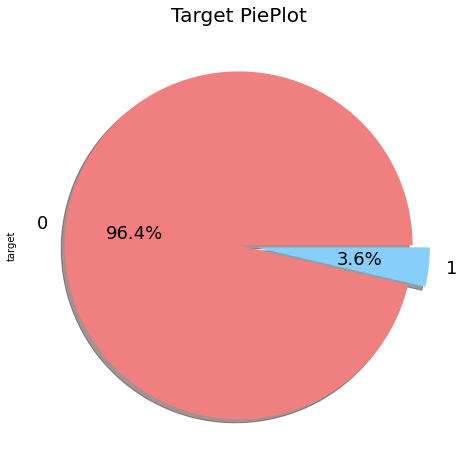

In [19]:
f, ax = plt.subplots(figsize = (8,8))

df_train['target'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', 
                                           shadow = True, colors = ['lightcoral', 'lightskyblue'],
                                           textprops={'fontsize': 18})
plt.title("Target PiePlot", size = 20)

In [20]:
desired_apriori=0.1

# Get the indices per target value
idx_0=df_train[df_train.target==0].index   # target=0인 값의 index
idx_1=df_train[df_train.target==1].index   # target=1인 값의 index

# target값(0,1) 에 따른 행 개수
nb_0=len(df_train.loc[idx_0]) # 573,518
nb_1=len(df_train.loc[idx_1]) # 21,694

print('nb_0: {}, nb_1: {}, nb_0 + nb_1: {}'.format(nb_0, nb_1, nb_0+nb_1))
nb_0_per = nb_0 / (nb_0+nb_1)
nb_1_per = nb_1 / (nb_0+nb_1)
print('nb_0의 비율: {}, nb_1의 비율: {}'.format(nb_0_per, nb_1_per))

# target=1은 0.9, target=0은 0.1
## ((1-0.1) * target=1인 데이터개수) / (target=0인 데이터개수 * 0.1) 
## Undersampling => 0.34
undersampling_rate=((1-desired_apriori)*nb_1)/(nb_0*desired_apriori) # 0.34

# 언더샘플링한 target=0인 데이터개수 = undersampling비율 x target=0인 데이터개수
## 기존 573,518 -> 195,246
undersampled_nb_0=int(undersampling_rate*nb_0)
print('target=0에 대한 undersampling비율 : {}'.format(undersampling_rate))
print('undersampling이후 target=0 데이터 개수: {}'.format(undersampled_nb_0))

# target=0인 전체index 중에서 언더샘플링할 개수 지정해서 랜덤으로 index선택
undersampled_idx=shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# undersampling된 index의 리스트와 기존 target=1인 index합친 리스트만들기
idx_list=list(undersampled_idx)+list(idx_1)

# undersampling된 데이터 반환
df_train=df_train.loc[idx_list].reset_index(drop=True)

nb_0: 573518, nb_1: 21694, nb_0 + nb_1: 595212
nb_0의 비율: 0.963552482140817, nb_1의 비율: 0.036447517859182946
target=0에 대한 undersampling비율 : 0.34043569687437886
undersampling이후 target=0 데이터 개수: 195246


# 5. Data Quality Checks

## 1) 결측치 확인

Missing values를 체크해보자 (-1로 되어있음)

In [21]:
vars_with_missing=[]

for f in df_train.columns:
    # 결측치 개수
    missings=df_train[df_train[f]==-1][f].count()
    if missings >0:
        vars_with_missing.append(f)
        # 결측치 비중
        missing_perc=missings/df_train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f,missings,missing_perc))

print()
print('In total, there are {} variables with missing values\n{}'.format(len(vars_with_missing), vars_with_missing))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values

In total, there are 12 variables with missing values
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_ca

#### 결측치가 너무많은 변수는 제거하고, 일부이면 평균 또는 최빈값으로 대치   

- ps_car_03_cat 변수와 ps_car_05_cat 변수는 결측치가 각각 68%, 44%로 너무 많으므로 제거
- 나머지 categorical 변수들의 결측치는 유지
- ps_reg_03(continuous) 변수는 18%가 결측치이므로, 평균으로 대치
- ps_car_11(ordinal) 변수는 1개의 record만 결측이므로 최빈값으로 대치
- ps_car_14(continuous) 변수는 7%가 결측치이므로 평균값으로 대치

In [22]:
# 결측치가 너무 많은 컬럼은 drop
vars_to_drop=['ps_car_03_cat','ps_car_05_cat']
df_train.drop(vars_to_drop, inplace=True, axis=1) # axis=1 → row

# 저장한 meta데이터에 drop한 컬럼의 상태 False로 바꾸기
meta.loc[(vars_to_drop),'keep']=False

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216940 entries, 0 to 216939
Data columns (total 57 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              216940 non-null  int64  
 1   target          216940 non-null  int64  
 2   ps_ind_01       216940 non-null  int64  
 3   ps_ind_02_cat   216940 non-null  int64  
 4   ps_ind_03       216940 non-null  int64  
 5   ps_ind_04_cat   216940 non-null  int64  
 6   ps_ind_05_cat   216940 non-null  int64  
 7   ps_ind_06_bin   216940 non-null  int64  
 8   ps_ind_07_bin   216940 non-null  int64  
 9   ps_ind_08_bin   216940 non-null  int64  
 10  ps_ind_09_bin   216940 non-null  int64  
 11  ps_ind_10_bin   216940 non-null  int64  
 12  ps_ind_11_bin   216940 non-null  int64  
 13  ps_ind_12_bin   216940 non-null  int64  
 14  ps_ind_13_bin   216940 non-null  int64  
 15  ps_ind_14       216940 non-null  int64  
 16  ps_ind_15       216940 non-null  int64  
 17  ps_ind_16_

In [24]:
meta[meta['keep'] == False]

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
ps_car_03_cat,input,nominal,False,int64
ps_car_05_cat,input,nominal,False,int64


In [25]:
# 평균 또는 최빈값으로 대치
# missing_values의 default값은 np.nan인데 여기서는 -1이 결측이므로 지정해줘야함.
mean_imp=SimpleImputer(missing_values=-1, strategy='mean')
mode_imp=SimpleImputer(missing_values=-1, strategy='most_frequent')

# 다차원 배열(array)을 1차원 배열로 평평하게 펴주는 NumPy의 ravel() 함수
## ex) array([[0.83],[0.72]]) -> array([0.83],[0.72])
df_train['ps_reg_03']=mean_imp.fit_transform(df_train[['ps_reg_03']]).ravel() # 평균
df_train['ps_car_14']=mean_imp.fit_transform(df_train[['ps_car_14']]).ravel() # 평균
df_train['ps_car_11']=mode_imp.fit_transform(df_train[['ps_car_11']]).ravel() # 최빈값(제일 빈도수가 높은 수로 대체)

## 2) Categorical변수의 cardinality(집합의 크기) 체크

Cardinality는 변수안에 서로다른 unique한 값의 개수를 말하는데, categorical변수에 많은 distinct value가 있으면 더미변수 개수가 너무 많아질수있음.   
따라서 이런 변수들을 다뤄보려고한다.

In [26]:
Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index

for f in Nominal:
    print(df_train[f].value_counts())
    dist_values = df_train[f].value_counts().shape
    print(dist_values)

 1    157124
 2     45273
 3     10310
 4      4130
-1       103
Name: ps_ind_02_cat, dtype: int64
(5,)
 0    125929
 1     90960
-1        51
Name: ps_ind_04_cat, dtype: int64
(3,)
 0    191764
 6      7844
 4      6785
 1      3064
 3      3050
-1      2256
 2      1584
 5       593
Name: ps_ind_05_cat, dtype: int64
(8,)
 11    76630
 7     64337
 6     22236
 10    18315
 4      9578
 9      7687
 5      6665
 8      5572
 3      2372
 0      2199
 2       806
 1       481
-1        62
Name: ps_car_01_cat, dtype: int64
(13,)
 1    178938
 0     38000
-1         2
Name: ps_car_02_cat, dtype: int64
(3,)
0    179946
1     12087
2      8812
8      7644
9      7236
6       641
3       236
5       210
4        74
7        54
Name: ps_car_04_cat, dtype: int64
(10,)
11    47385
1     42919
0     40004
14    21535
10    12401
4     11262
15     8164
6      7702
9      6664
7      5968
3      4414
13     2353
17     1878
16     1753
12      869
2       612
8       540
5       517
Name: ps_car

In [27]:
for f in Nominal:
    print('Variable {} has {} distinct values'.format(f, df_train[f].nunique()))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


ps_car_11_cat 변수만이 distinct value개수가 많다.

### distinct한 값이 너무 많은 카테고리변수 ps_car_11_cat를 처리하는 방법

#### 범주형 변수 인코딩

- 범주형 변수를 인코딩하는 방법에서 일반적으로 one-hot-encoding, Label-encoding 방법을 사용한다.
- 두 가지 방법이 어떻게 이루어지는지는 다들 알거라 생각하고 생략한다.
- one-hot-encoding은 변수에 순서(높고 낮음)이 부여되지 않기 때문에 target을 예측하는데 영향을 주진 않지만 unique값이 많을 경우 굉장히 sparse한 벡터가 생성되고, 또한 faeture도 기하급수적으로 늘어나기 때문에 cost가 늘어나고 차원의 저주에 빠질 확률이 높아진다.
- Label-encoding의 경우 feature가 유지되기 때문에 cost가 적고 차원을 신경쓸 필요가 없지만 각각 unique 값에 매핑되는 숫자에 순서가 생겨버리기 때문에 target 예측에 영향을 줄 수 있다.
- 이 커널에서는 mean-encoding이라는 방법을 사용했다.

#### mean-encoding

- 어떻게 이루어지는에 대한 설명은 아래 예시와 같다.
- 캐글에서는 mean encoding, frequency encoding 등 방법들을 많이 사용한다고 한다.
- 차원의 저주에 빠질 확률이 없고 빠르다는 장점이 있다.
- 가장 큰 장점으로는 target과의 mean을 취해주었기 때문에 일종의 상관관계를 가지게 된다.
- 하지만 치명적인 단점이 있다.
- 바로 Data Leakage 문제와 오버피팅 문제이다.
- test 및 추후 수집될 데이터 셋에 대한 target 값을 알지 못하기 때문에 target에 대한 평균을 train 데이터 셋으로만 적용시켜야 한다.
- 그렇기 때문에 test 셋의 target 값을 사용하게 되면 data leakage 문제에 빠지게되고, train 셋의 target 값만 사용하게 되면 오버피팅되는 딜레마가 있다.
- 특히 train, test 셋의 unique값 분포가 크게 다를 때 오버피팅 문제는 커지게 된다.
- ex. train 셋의 남자 95명 여자5명, test 셋의 남자 50명, 여자 50명

#### 단점을 어떻게 극복하는가?

- 이러한 단점들을 완화시키기 위한 방법들이 여러가지 있다.   
1) smoothing   
2) CV   
3) Expanding mean   
출처: https://dailyheumsi.tistory.com/120

#### assert 예제

In [28]:
# xyz = 1
# assert xyz == 1
# print('성공')

In [29]:
# assert xyz == 2 # AssertionError 발생
# print('성공')

In [30]:
# 커널에서 구현한 mean-encoding 코드
# 코드가 매우 복잡해보이지만 결국 위에서 보았던 예제 방식을 구현한 것이다.
# 오버피팅 방지를 위해 noise를 추가하고, smoothing을 적용하기 때문에 코드가 복잡해보인다.
# smoothing을 통해 평균값이 치우친 상황을 조금이나마 보완해준다. (전체 평균값으로 가깝게)
# smoothing에 대한 자세한 이론은 위의 설명에 있는 출처 링크에서 확인! 

# 오버피팅 방지를 위해 약간의 noise를 추가한다고 한다.
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    
    assert len(trn_series) == len(target) # assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.
    assert trn_series.name == tst_series.name
    
    # 216,940 → 위에서 undersampling한 target=0인 개수(195,246)와 target=1인 개수(21,694)를 합친 개수와 동일
    print(len(trn_series), len(target))
    print()
    print(len(df_train)) # 216,940 → target=0인 개수와 target=1인 개수를 합하면 전체 개수가 된다.
    print()
    
    temp = pd.concat([trn_series, target], axis=1) # df_train의 'ps_car_11_cat' 컬럼과 'target' 컬럼을 합해서 새로운 DataFrame객체 생성
    print('------ temp ------')
    print(temp)
    print()
    
    # agg를 사용해서 평균값을 구해줌
    # agg는 여러 함수를 한 번에 적용하고 싶을 때 사용
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["sum", "mean", "count"]) # (trn_series)마다 [target값]의 [평균, 개수]
    print('------ averages ------')
    print(averages)
    print()
    
    # 오버피팅 방지를 위한 smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    print('------ smoothing ------')
    print(smoothing)
    print()
    prior = target.mean()
    print('------ prior ------')
    print(prior)
    print()
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["sum", "mean", "count"], axis=1, inplace=True)
    print('------ averages ------')
    print(averages)
    print()
    
    # train, test에 적용시켜준다.
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name), # to_frame: Series객체를 DataFrame객체로 변환
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                             on=trn_series.name, # trn_series를 기준으로 merge
                             how='left')['average'].rename(trn_series.name + '_mean').fillna(prior) # fillna: 결측값을 설정한 값으로 채움
    
    ft_trn_series.index = trn_series.index 
    print('------ ft_trn_series ------')
    print(ft_trn_series)
    print()
    
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                             on=tst_series.name, # tst_series를 기준으로 merge
                             how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  
    ft_tst_series.index = tst_series.index
    print('------ ft_tst_series ------')
    print(ft_tst_series)
    print()
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [31]:
# 위에서 구현한 함수를 ps_car_11_cat(104개의 유니크 값)에 적용시켜준다.
# feature가 바뀌었으므로 메타데이터를 업데이트 해준다.

train_encoded, test_encoded = target_encode(df_train["ps_car_11_cat"], 
                                            df_test["ps_car_11_cat"], 
                                            target=df_train['target'], 
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

print('------ train_encoded ------')
print(train_encoded)
print()

print('------ test_encoded ------')
print(test_encoded)
print()

df_train['ps_car_11_cat_te'] = train_encoded
df_train.drop('ps_car_11_cat', axis=1, inplace=True)

meta.loc['ps_car_11_cat','keep'] = False

df_test['ps_car_11_cat_te'] = test_encoded
df_test.drop('ps_car_11_cat', axis=1, inplace=True)

216940 216940

216940

------ temp ------
        ps_car_11_cat  target
0                  26       0
1                 104       0
2                  15       0
3                  74       0
4                  78       0
...               ...     ...
216935            104       1
216936              5       1
216937            104       1
216938            104       1
216939             57       1

[216940 rows x 2 columns]

------ averages ------
                sum      mean  count
ps_car_11_cat                       
1               135  0.108260   1247
2                97  0.103082    941
3               163  0.139078   1172
4                97  0.164966    588
5               525  0.113000   4646
...             ...       ...    ...
100             233  0.138773   1679
101             281  0.108035   2601
102              71  0.097127    731
103             647  0.074703   8661
104            3830  0.121199  31601

[104 rows x 3 columns]

------ smoothing ------
ps_car_11_cat
1  

In [32]:
meta[meta['keep'] == False]

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
ps_car_03_cat,input,nominal,False,int64
ps_car_05_cat,input,nominal,False,int64
ps_car_11_cat,input,nominal,False,int64


# 6. 시각화를 통한 데이터 탐색

## 1) 범주형 변수 시각화   

target이 1인 범주형 변수들의 특성을 시각화를 통해 파악해본다.

In [33]:
df_train['ps_ind_02_cat'].value_counts()

 1    157124
 2     45273
 3     10310
 4      4130
-1       103
Name: ps_ind_02_cat, dtype: int64

In [34]:
df_train[['ps_ind_02_cat','target']]

,ps_ind_02_cat,target
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
216935,1,1
216936,1,1
216937,1,1
216938,2,1


In [35]:
df_train[['ps_ind_02_cat','target']].groupby(['ps_ind_02_cat'],as_index=False).agg(['count', 'sum', 'mean'])

target                 
                count    sum      mean
ps_ind_02_cat                         
-1                103     40  0.388350
 1             157124  15428  0.098190
 2              45273   4713  0.104102
 3              10310   1049  0.101746
 4               4130    464  0.112349

<Figure size 432x288 with 0 Axes>

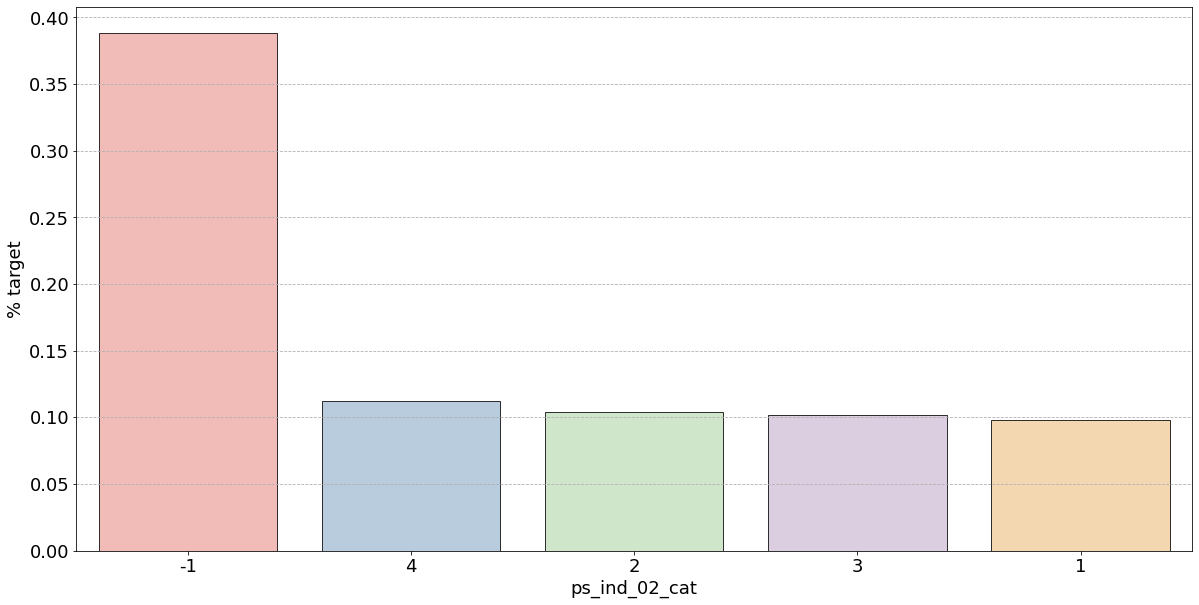

<Figure size 432x288 with 0 Axes>

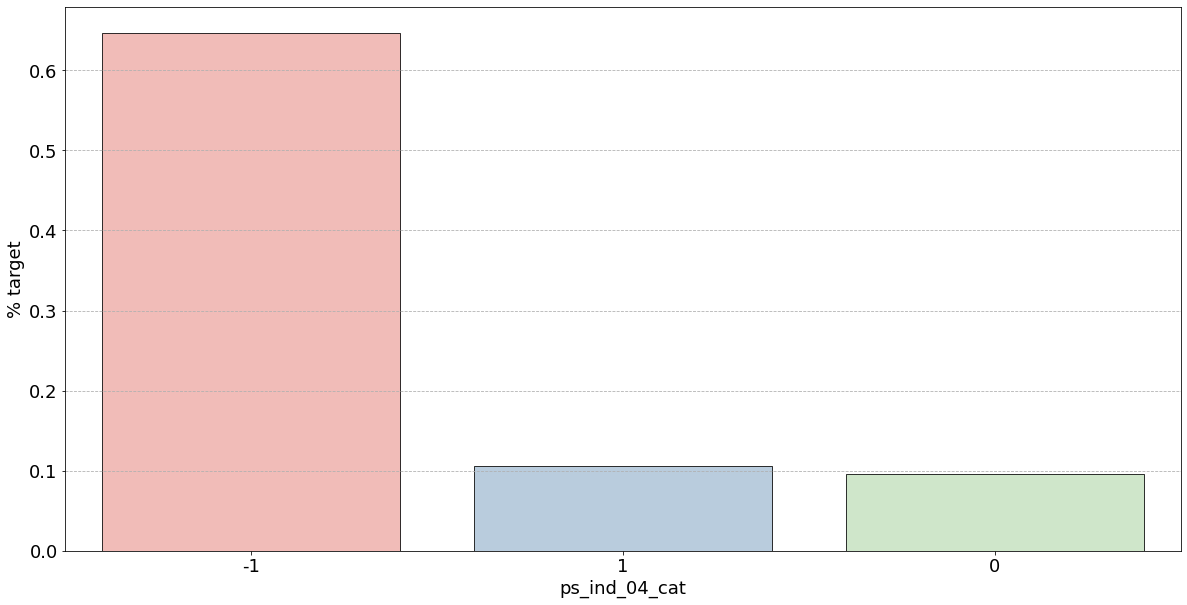

<Figure size 432x288 with 0 Axes>

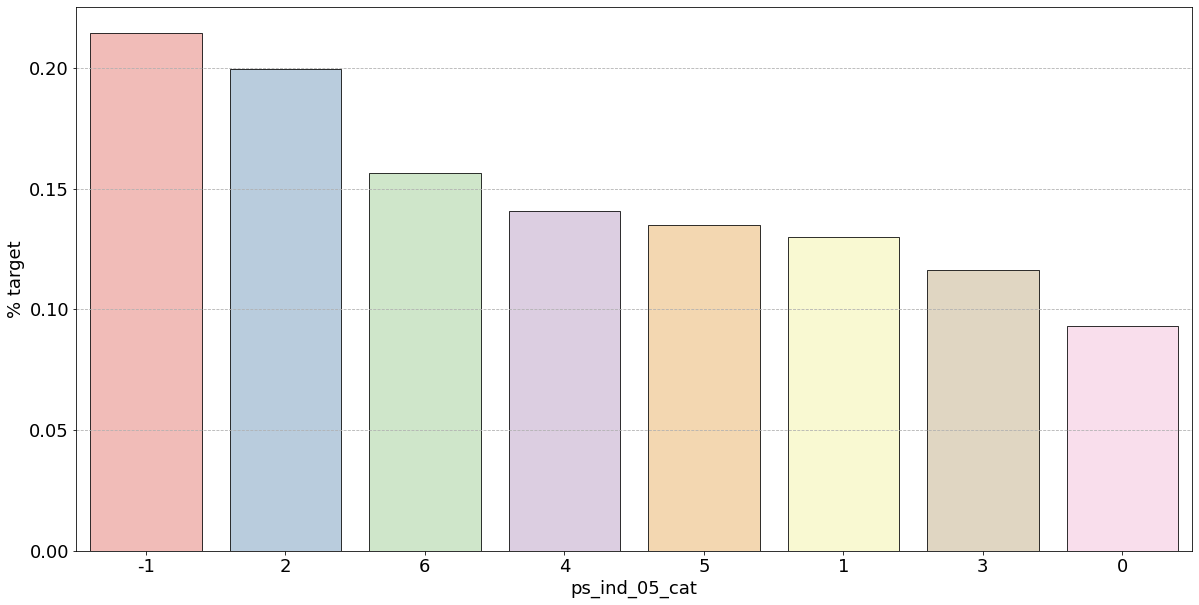

<Figure size 432x288 with 0 Axes>

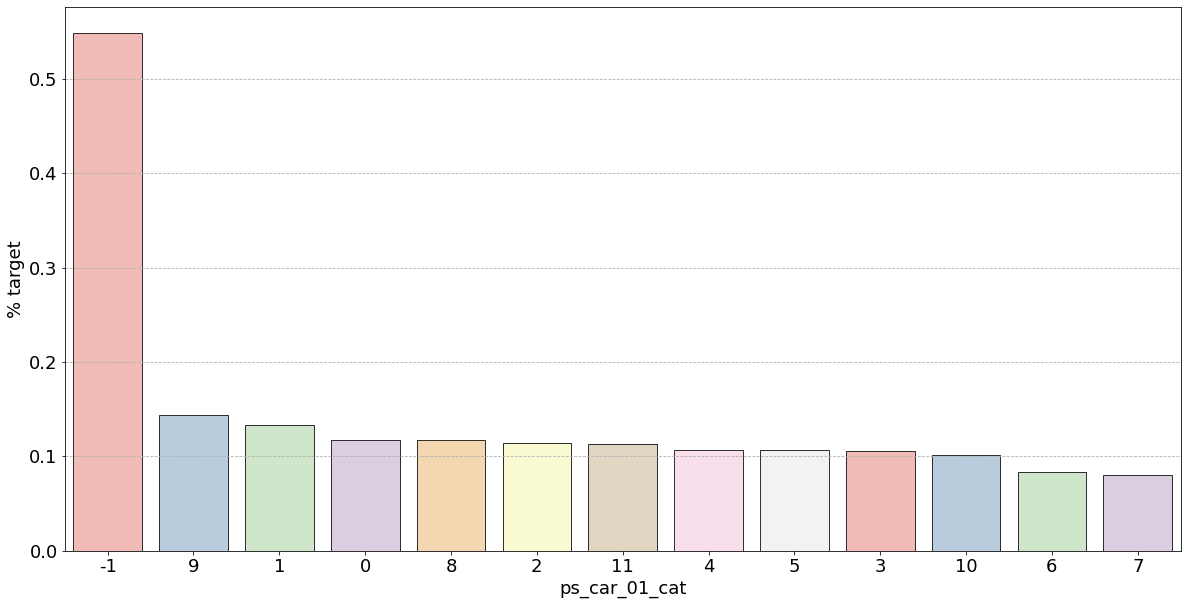

<Figure size 432x288 with 0 Axes>

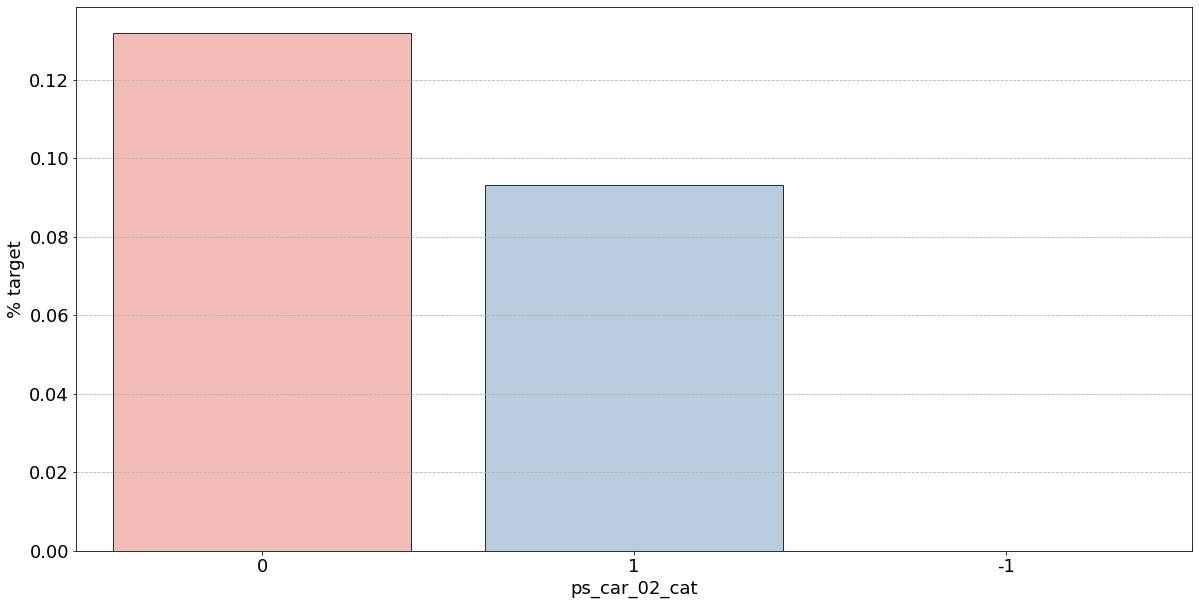

<Figure size 432x288 with 0 Axes>

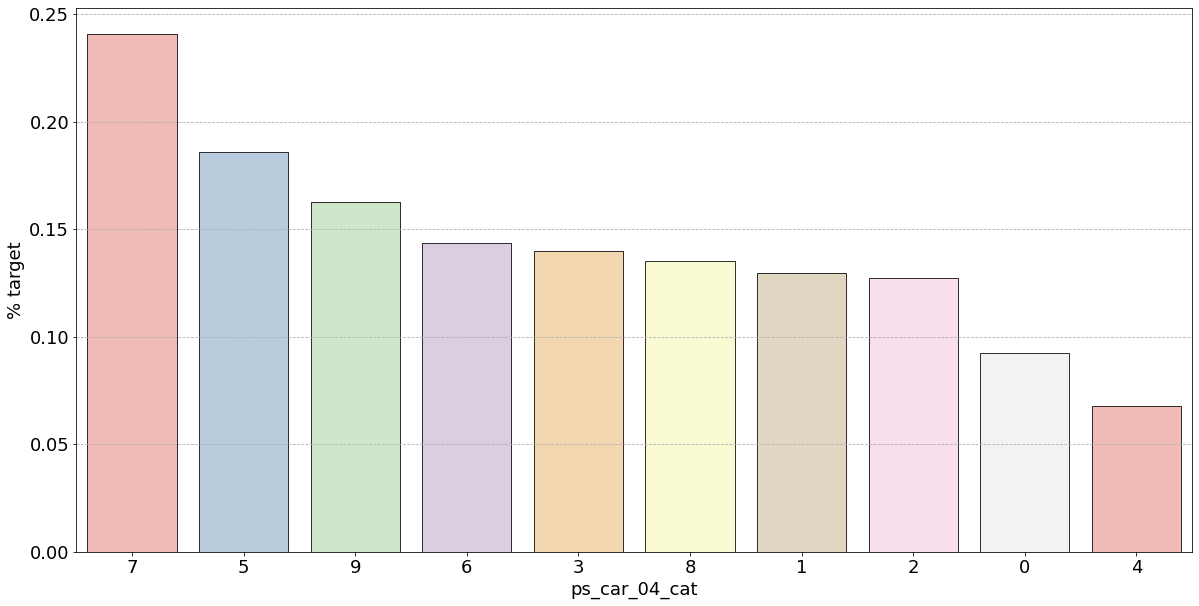

<Figure size 432x288 with 0 Axes>

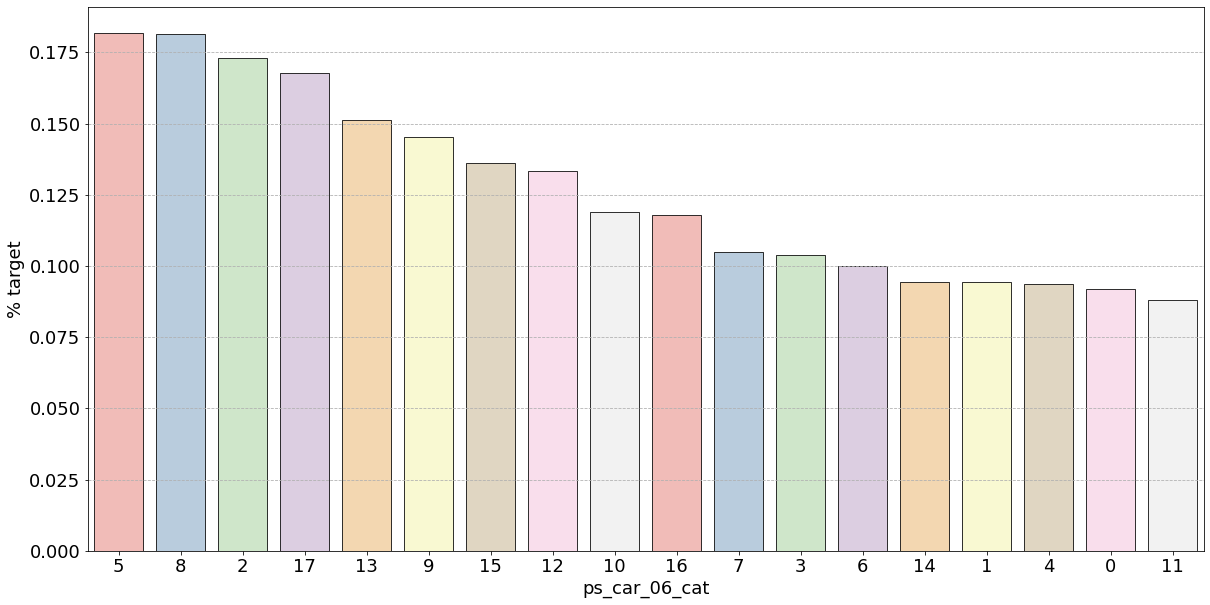

<Figure size 432x288 with 0 Axes>

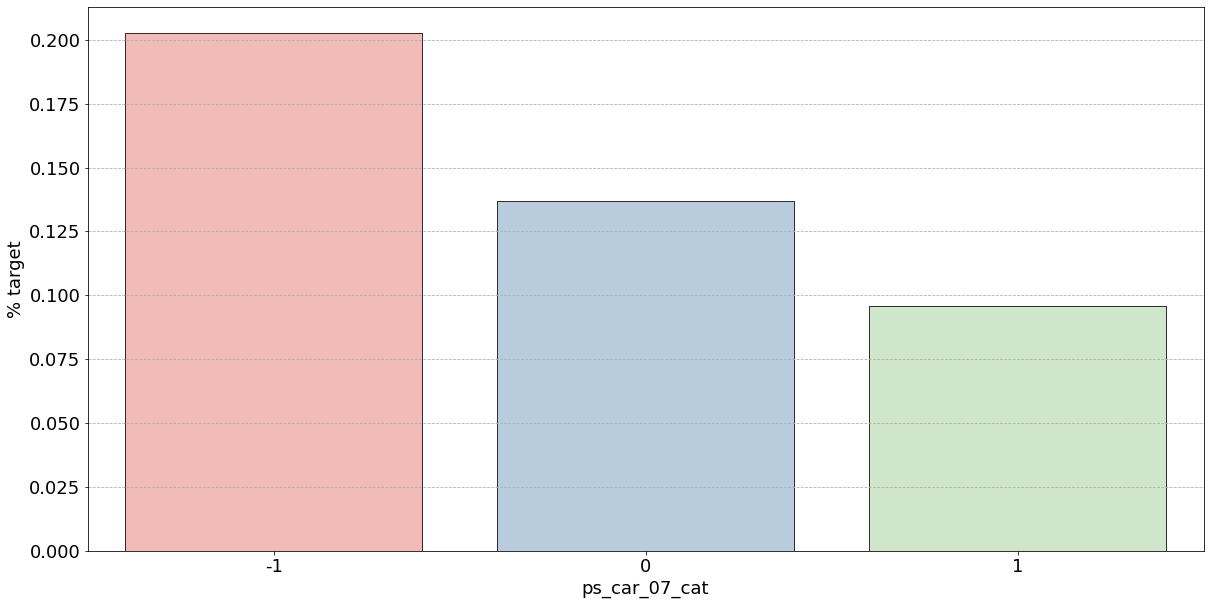

<Figure size 432x288 with 0 Axes>

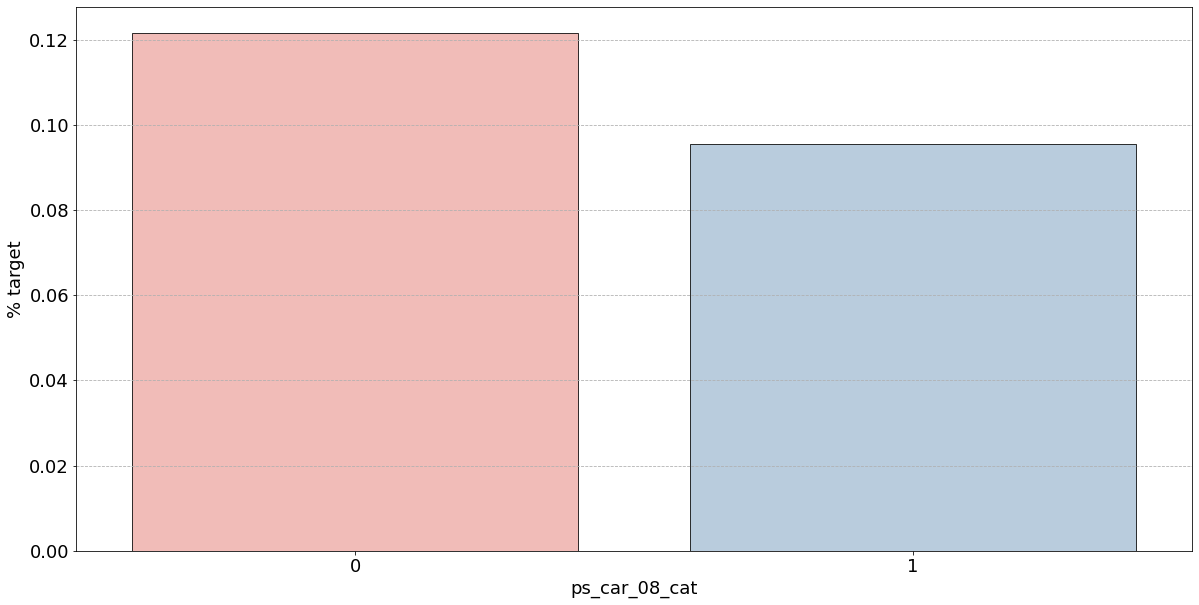

<Figure size 432x288 with 0 Axes>

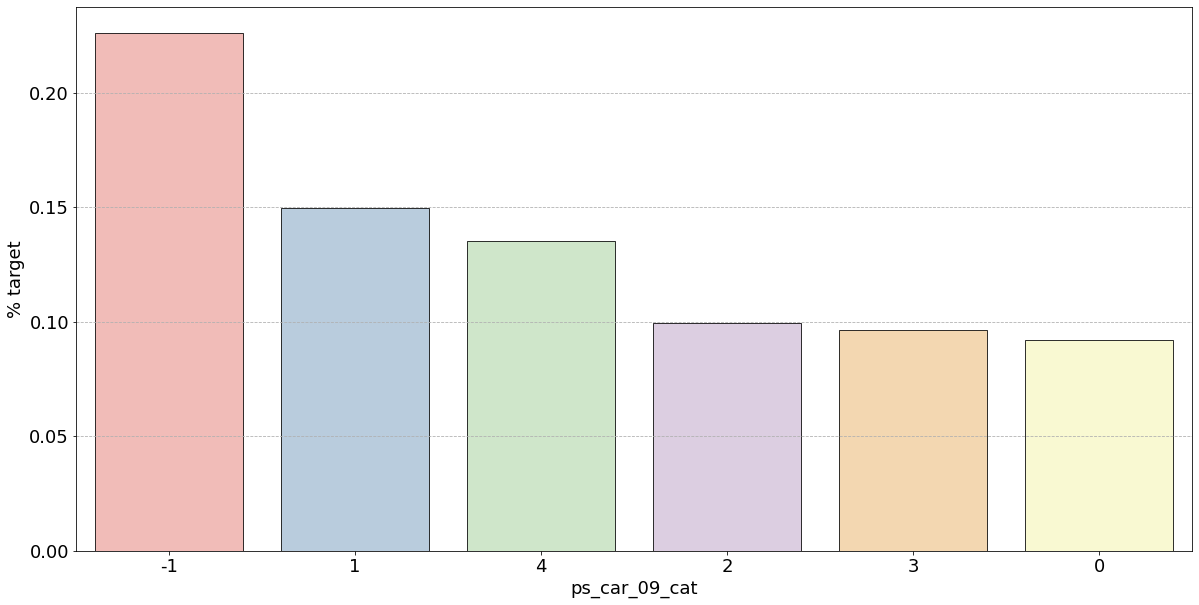

<Figure size 432x288 with 0 Axes>

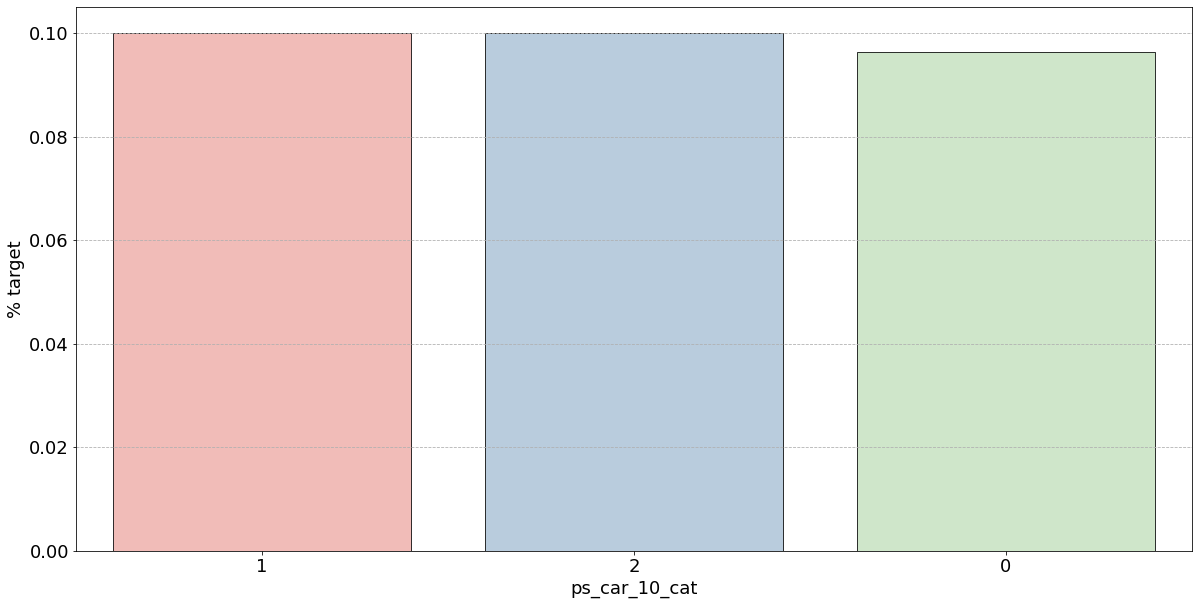

In [36]:
Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index

# 변수별로 반복문을 돌려서 barplot을 그린다.
for f in Nominal:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.grid(axis = "y", linestyle='--')
    
    # 변수 별 target=1의 비율 계산
    cat_perc = df_train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # 위에서 계산해준 비율을 통해 target=1의 데이터 중 어떤 유니크값의 비율이 높은지 확인할 수 있다.
    sns.barplot(ax=ax, x=f, y='target',palette = "Pastel1", edgecolor='black', linewidth=0.8, data=cat_perc, order=cat_perc[f], )
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18) # 눈금관련
    plt.show();

결측치를 최빈값으로 대치하지 않고, 카테고리 값으로 분리해서 살펴본것은 바람직했던 것으로 보인다.   
결측치가 있는 고객들은 보험청구를 요구했을 가능성이 더 높은것으로 나타났다. (어떤경우는 낮기도함)

## 2) Interval 변수 시각화 (연속형)

heatmap으로 상관관계 파악

In [37]:
def corr_heatmap(Interval):
    correlations = df_train[Interval].corr() # corr(): 상관관계 구하는 함수
    print('------ df_train[' + str(Interval) + '] ------')
    print(df_train[Interval]) # 실수 형태의 값을 가지고있는 컬럼 모음
    print()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True) # 양쪽으로 발산하는 Color Palette

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()

------ df_train[Index(['target', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02',
       'ps_calc_03'],
      dtype='object', name='varname')] ------
        target  ps_reg_01  ps_reg_02  ps_reg_03  ps_car_12  ps_car_13  \
0            0        0.6        0.6   0.838153   0.368782   0.540603   
1            0        0.9        0.6   0.728440   0.424264   0.382953   
2            0        0.9        0.6   0.869267   0.400000   0.814271   
3            0        0.6        1.5   1.705872   0.400000   0.838387   
4            0        0.8        0.8   1.086566   0.400000   0.905777   
...        ...        ...        ...        ...        ...        ...   
216935       1        0.6        0.4   1.537652   0.424264   1.269111   
216936       1        0.3        0.4   0.898861   0.424264   0.756979   
216937       1        0.9        0.3   0.711952   0.400000   0.970654   
216938       1        0.6        0.1   0.57

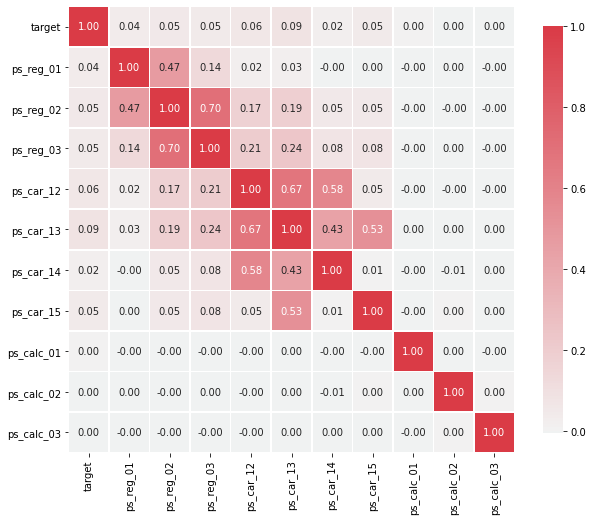

In [38]:
Interval = meta[(meta["role"] == "target") | (meta["level"] == 'interval') & (meta["keep"])].index
corr_heatmap(Interval)

#### 변수간에 상관관계가 높은 변수들이 있는것을 확인할 수 있다.   

- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.53)

### ① ps_reg_02 & ps_reg_03

- plot을 보면 두 개의 변수가 선형관계를 이루는 것을 확인할 수 있다.   
- 회귀선이 겹치거나 비슷한 모습이다.

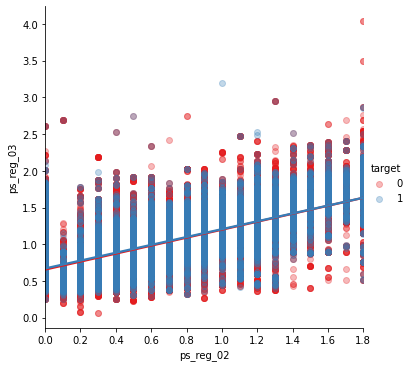

In [39]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ② ps_car_12 & ps_car_13

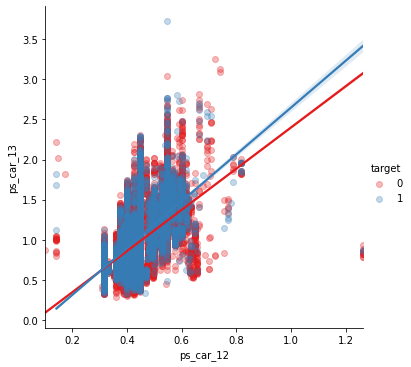

In [40]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ③ ps_car_12 and ps_car_14

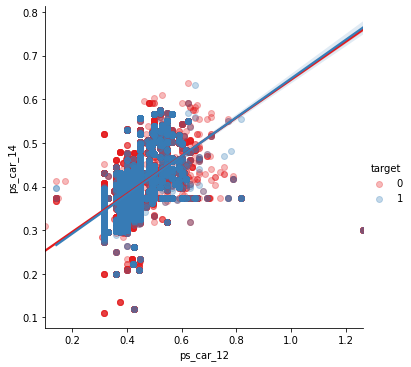

In [41]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ④ ps_car_13 & ps_car_15

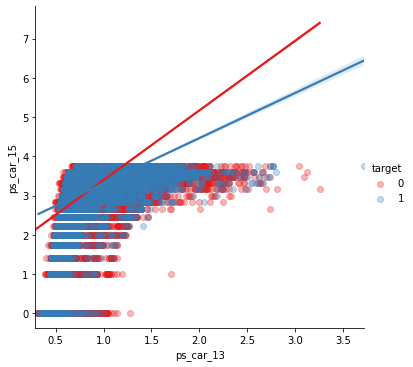

In [42]:
sns.lmplot(x='ps_car_13', y='ps_car_15', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

- 서로 상관이있는 변수를 어떻게 결정하고 남겨둘것인가?   
우리는 차원을 줄이기위해 변수에 Principal Component Analysis (PCA) 를 적용해볼수있다.   
그러나, 상관관계가 있는 변수들의 수가 적기때문에 모델이 알아서 하게 두기로한다.

### ⑤ ps_car_14 & ps_reg_03 (상관관계 낮은 변수)

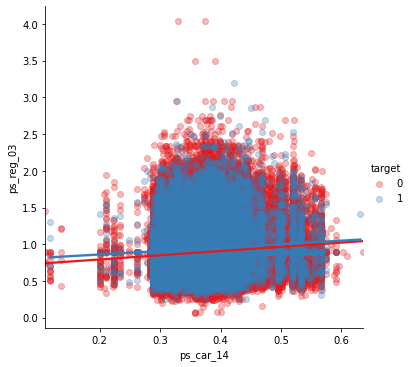

In [43]:
# ps_car_14 와 ps_reg_03 간의 상관관계는 0.08
sns.lmplot(x='ps_car_14', y='ps_reg_03', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

## 3) Ordinal 변수 시각화

------ df_train[Index(['target', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15',
       'ps_car_11', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07',
       'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12',
       'ps_calc_13', 'ps_calc_14'],
      dtype='object', name='varname')] ------
        target  ps_ind_01  ps_ind_03  ps_ind_14  ps_ind_15  ps_car_11  \
0            0          1          1          0         11          1   
1            0          5          7          0          5          1   
2            0          4          3          0          4          3   
3            0          6          6          0          8          2   
4            0          5          5          0         10          3   
...        ...        ...        ...        ...        ...        ...   
216935       1          5          7          0          8          1   
216936       1          1          5          0          4          2   
216937       1         

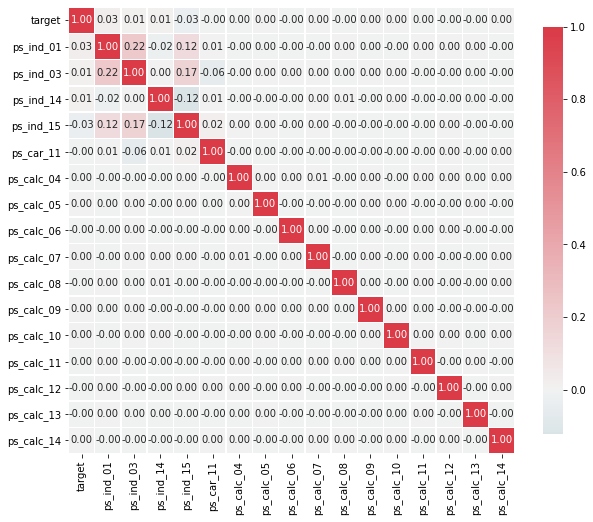

In [44]:
Ordinal = meta[(meta["role"] == "target") | (meta["level"] == 'ordinal') & (meta["keep"])].index
corr_heatmap(Ordinal)

# 7. Feature Engineering

## 1) 더미변수 만들기

카테고리변수는 어떤 순서나 단위를 나타내지 않는다. 예를들어 카테고리 2가 카테고리 1의 두배라고 할 수 없다.

In [45]:
Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index # nominal: 카테고리값을 가지는 변수 모음
print('One-Hot Encoding 전 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))

df_train = pd.get_dummies(df_train, columns=Nominal, drop_first=True) # drop_first=True: 인코딩된 컬럼 중 첫 번째 컬럼 삭제
df_test = pd.get_dummies(df_test, columns=Nominal, drop_first=True)
print('One-Hot Encoding 후 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))

One-Hot Encoding 전 train 데이터 셋 변수 개수: 57
One-Hot Encoding 후 train 데이터 셋 변수 개수: 109


In [46]:
df_train

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,...,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,ps_car_06_cat_10,ps_car_06_cat_11,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_14,ps_car_06_cat_15,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_07_cat_0,ps_car_07_cat_1,ps_car_08_cat_1,ps_car_09_cat_0,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_10_cat_1,ps_car_10_cat_2
0,353762,0,1,1,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1,0.093965,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
1,845629,0,5,7,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0,0.120151,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0
2,1449185,0,4,3,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1,0.096032,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
3,834066,0,6,6,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,2,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0,0.086148,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0
4,436189,0,5,5,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,3,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1,0.107493,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,1487473,1,5,7,0,0,1,0,0,0,0,0,0,8,0,1,0,0.6,0.4,1.537652,1,0.424264,1.269111,0.384708,3.162278,0.5,0.1,0.5,3,4,9,1,10,2,9,10,1,5,7,0,1,1,0,0,0,0.120327,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
216936,1487566,1,1,5,0,0,1,0,0,0,0,0,0,4,0,0,1,0.3,0.4,0.898861,2,0.424264,0.756979,0.400000,2.000000,0.3,0.4,0.6,1,1,8,2,9,5,9,9,2,1,5,0,1,0,0,0,0,0.111936,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0
216937,1487716,1,0,6,0,1,0,0,0,0,0,0,0,9,0,1,0,0.9,0.3,0.711952,3,0.400000,0.970654,0.372424,3.464102,0.5,0.4,0.6,2,2,8,2,8,4,10,3,2,1,6,0,1,1,0,0,0,0.121085,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0
216938,1487748,1,0,2,1,0,0,0,0,0,

In [47]:
df_test

,id,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_03_cat,ps_car_05_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,...,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,ps_car_06_cat_10,ps_car_06_cat_11,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_14,ps_car_06_cat_15,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_07_cat_0,ps_car_07_cat_1,ps_car_08_cat_1,ps_car_09_cat_0,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_10_cat_1,ps_car_10_cat_2
0,0,0,8,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,-1,-1,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1,0.083532,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
1,1,4,5,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,-1,0,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1,0.074504,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0
2,2,5,3,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,-1,-1,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0,0.098552,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0
3,3,0,6,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,-1,-1,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0,0.098453,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
4,4,5,7,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,-1,-1,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1,0.108860,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892811,1488022,0,6,0,1,0,0,0,0,0,0,0,2,0,0,1,0.5,0.3,1.048809,-1,0,2,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0,0.181397,1,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0
892812,1488023,5,5,0,0,1,0,0,0,0,0,0,11,1,0,0,0.7,1.0,1.246495,-1,0,2,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0,0.103072,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
892813,1488024,0,5,1,0,0,0,0,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,-1,-1,2,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0,0.117335,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
892814,1488025,6,5,0,0,0,1,0,0,0,0,

52개의 변수가 늘어났다.

## 2) interaction 변수 만들기 (다항회귀)

https://chana.tistory.com/entry/핸즈온-머신러닝5-다항-회귀

> Q : 2차항 변수를 만드는 이유는 ? 어떤경우에 ?   
A : 데이터들간의 형태가 비선형일때 데이터에 각 특성의 제곱을 추가해서 특성이 추가된 비선형 데이터를 선형회귀 모델로 훈련시키는 방법

In [48]:
Interval = meta[(meta["level"] == 'interval') & (meta["keep"])].index

# 2차항 변수 만들기
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# interactions변수에는 기존 데이터와 제곱한 데이터가 모두 포함된다.
interactions = pd.DataFrame(data=poly.fit_transform(df_train[Interval]), columns=poly.get_feature_names(Interval))
# interactions 데이터프레임에서 기존 변수 삭제
interactions.drop(Interval, axis=1, inplace=True)

In [49]:
# train데이터에 interaction변수를 concat한다. 즉, 기존 변수에 interval변수의 2차항 변수들을 추가
print('교호작용 변수 생성 전 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))
df_train = pd.concat([df_train, interactions], axis=1)
df_test = pd.concat([df_test, interactions], axis=1)
print('교호작용 변수 생성 후 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))

교호작용 변수 생성 전 train 데이터 셋 변수 개수: 109
교호작용 변수 생성 후 train 데이터 셋 변수 개수: 164


In [50]:
# 만들어진 feature 확인
df_train.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,...,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,353762,0,1,1,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1,0.093965,1,0,0,0,...,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,845629,0,5,7,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0,0.120151,1,0,0,0,...,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,1449185,0,4,3,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1,0.096032,1,0,0,0,...,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,834066,0,6,6,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,2,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0,0.086148,1,0,0,0,...,0.227051,2.163331,0.48,0.24,0.06,2.25,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,2.910000,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.160,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.702893,0.317260,3.022847,0.670710,0.335355,0.083839,0.1432,1.364405,0.302734,0.151367,0.037842,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,436189,0,5,5,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,3,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1,0.107493,1,0,0,0,...,0.307870,2.884441,0.48,0.40,0.72,0.64,0.869253,0.